# DAY 2: Models - Exercise 6.
RECAP: <br>
1. In Ex-1 We used OBS data to decide wether rainfall was higher or lower than average and assigned it a catagory.
2. in Ex-2 we used hindcasts to compare old forecasts to an oberved rainfall of the same period.
3. in Ex-3 we looked at how ensembles produce a small range that can when averaged can be better than a single members forecast.
4. in Ex-4 we looked at how ensembles can be bias corrected.
5. in Ex-5 we looked at sorting members via prediceted probabilites into three tercile catagories.<br>
In this excersice we will be: <br>
1. Constructing a real time forecast using forecast and hind-cast data.<br>

The data for this excersise is below - the start data is the same data as Ex-2, Ex-3 and Ex-4<br>
A forecasted amount of rainfall is given for each year and the months OND. <br>
The second data is going to act as the real-time data. It is 2023 ensemble forecast. 

In [1]:
import numpy as np
import xarray as xr
from Data import location
da = location('Kenya')

Rainfall for 1994, Member 2: 4.38


In [2]:
RFA_obs = ([1.52,2.93,1.95,1.51,5.56,1.33,2.04,2.34,1.99,2.95,1.90,2.40,1.15,4.31,1.83,1.98,2.65,1.55,3.86,2.72,2.25,2.31,3.13,1.70])
Obs_Anom =[-0.8908333333333331, 0.519166666666667, -0.4608333333333332, -0.9008333333333332, 3.1491666666666664, -1.080833333333333, 
           -0.3708333333333331, -0.0708333333333333, -0.42083333333333317, 0.539166666666667, -0.5108333333333333, -0.01083333333333325, 
           -1.2608333333333333, 1.8991666666666664, -0.5808333333333331, -0.4308333333333332, 0.23916666666666675, -0.8608333333333331, 
           1.4491666666666667, 0.30916666666666703, -0.16083333333333316, -0.10083333333333311, 0.7191666666666667, -0.7108333333333332]

Finally, the data for 2023. 

In [3]:
Ens_Mem = [f"Member {i}" for i in range(1, 52)]

data_em = [3.41,3.65,4.10,4.45,4.48,3.48,4.29,5.01,4.81,4.40,3.08,2.68,4.28,3.25,4.13,4.31,3.25,3.09,3.96,5.39,5.95,4.05,
           3.33,3.18,5.18,4.44,2.89,2.82,3.84,3.08,2.52,3.07,4.91,3.96,3.90,3.91,3.18,2.53,3.03,2.61,2.27,2.92,5.20,3.77,
           3.26,3.81,2.67,2.96,5.55,4.50,3.57]
da_FC = xr.DataArray(data_em, coords={"member": Ens_Mem}, dims=["member"])
print("In example if we take the forecast year (2023), and the member number 2, the rainfall predicted of OND was 3.41 mm/day")
print("Rainfall for 2023, Member 2:", da_FC.sel(member="Member 2").item(), "mm/day")

In example if we take the forecast year (2023), and the member number 2, the rainfall predicted of OND was 3.41 mm/day
Rainfall for 2023, Member 2: 3.65 mm/day


**The cell below now repeats everything we have done in the previous excersises in one go.**<br>
Specfically, This is all the work from Ex-2 to Ex-5

In [4]:
#This is from EX-5
RFA_upper = np.percentile(da, 66.66666)
RFA_lower = np.percentile(da, 33.33333)


Yearly_Forecast_member_below = []
Yearly_Forecast_member_above= []
Yearly_Forecast_member_between = []


#now we select for each member
for i in range(da.sizes['year']):
         data = da.isel(year=i)
         cat_0_mask = data < RFA_lower
         Yearly_Forecast_member_below.append(cat_0_mask)
         cat_1_mask = data > RFA_upper
         Yearly_Forecast_member_above.append(cat_1_mask)
         cat_2_mask = (data >= 2.22) & (data <= 2.98)
         Yearly_Forecast_member_between.append(cat_2_mask)
  
 #Now we will join this back into one single list
Yearly_Forecast_below= xr.concat(Yearly_Forecast_member_below, dim='year')
Yearly_Forecast_above= xr.concat(Yearly_Forecast_member_above, dim='year')
Yearly_Forecast_between= xr.concat(Yearly_Forecast_member_between, dim='year')

Yearly_Counts_Below = Yearly_Forecast_below.sum(dim="member")
Yearly_Counts_Above = Yearly_Forecast_above.sum(dim="member")
Yearly_Counts_Between = Yearly_Forecast_between.sum(dim="member")

#Again we create an empty array. 
Yearly_percentage_Below = []
Yearly_percentage_Above = []
Yearly_percentage_Between = []

# We select for each individual year
for i in range(Yearly_Counts_Below.sizes['year']):
    #We do the percentage calulcation
    percentage = (Yearly_Counts_Below.isel(year=i).item() / da.member.size) *100
    Yearly_percentage_Below.append(percentage)
    percentage = (Yearly_Counts_Above.isel(year=i).item() / da.member.size) *100
    Yearly_percentage_Above.append(percentage)
    percentage = (Yearly_Counts_Between.isel(year=i).item() / da.member.size) *100
    Yearly_percentage_Between.append(percentage)
   
RFA_upper_obs = np.percentile(RFA_obs, 66.66666)
RFA_lower_obs = np.percentile(RFA_obs, 33.33333)

RFANP = np.array(RFA_obs)

# Now we will see if values in the array are greater than RFA_upper (2.48)
# If they are they will be turned into a '3'
RFANP[RFANP>RFA_upper_obs]= 3

#We now repeat this for RFA lower and RFA_middle
RFANP[RFANP<RFA_lower_obs]= 1
RFANP[(RFANP<RFA_upper_obs)&(RFANP>RFA_lower_obs)]= 2

RFA_Catagories = RFANP 

#This is from EX-4

ECMWF_Climate_Mean =  da.mean().item()
Bias_corrected = da - ECMWF_Climate_Mean
#First we create an empty array to store the data in
BC_Yearly_Forecast_mean = []
BC_Yearly_Forecast_min = []
BC_Yearly_Forecast_max = []
BC_Yearly_Forecast_LQ = []
BC_Yearly_Forecast_UQ = []


#Then we need to select for each year all the values accosiated with it
for year in Bias_corrected.year.values:
    data = Bias_corrected.sel(year=year)
    #Now we can repeat the EX-2 needed items
    mean = data.mean().item()
    Max = data.max().item()
    Min = data.min().item()
    LQ = np.percentile(data, 25.00, method = 'closest_observation')
    UQ = np.percentile(data, 75.00, method = 'closest_observation')
    #Now we can store them into the list
    BC_Yearly_Forecast_mean.append(mean)
    BC_Yearly_Forecast_min.append(Min)
    BC_Yearly_Forecast_max.append(Max)
    BC_Yearly_Forecast_LQ.append(LQ)
    BC_Yearly_Forecast_UQ.append(UQ)
    
Obs_A = np.array(Obs_Anom)

Obs_A[Obs_A>BC_Yearly_Forecast_max]= 2
Obs_A[Obs_A<BC_Yearly_Forecast_min]= 2
Obs_A[(Obs_A<BC_Yearly_Forecast_max)&(Obs_A>BC_Yearly_Forecast_min)]= 1
Obs_A_Catagories = Obs_A

count = np.count_nonzero(Obs_A_Catagories == 1)

#This is from Ex-3
RF_upper_quantile = np.percentile(da, 75.00)
RF_lower_quantile = np.percentile(da, 25.00)

#First we create an empty array to store the data in
Yearly_Forecast_LQ = []
Yearly_Forecast_UQ = []

#Then we need to select for each year all the values accosiated with it
for year in da.year.values:
    data = da.sel(year=year)
    
    #now we can use the functions as above to return the yearly quantiles
    RF_lower_quantile = np.percentile(data, 25.00, method = 'closest_observation')
    RF_upper_quantile = np.percentile(data, 75.00, method = 'closest_observation')
    
    #Now we can store them into the list
    Yearly_Forecast_UQ.append(RF_upper_quantile)
    Yearly_Forecast_LQ.append(RF_lower_quantile)

    #Yearly_Forecast_LQ.append( ) -edit
    #Yearly_Forecast_UQ.append( ) -edit

#Finally we round the values in the list for easy readability 
Yearly_Forecast_LQ = np.round(Yearly_Forecast_LQ,3)
Yearly_Forecast_UQ = np.round(Yearly_Forecast_UQ,2)

#This is from Ex-2

#First we create an empty array to store the data in
Yearly_Forecast_mean = []

#Then we need to select for each year all the values accosiated with it
for year in da.year.values:
    data = da.sel(year=year)
    #now we can use the function mean to return the yearly mean across the members 
    mean = data.mean().item()
    #Now we can store them into the list
    Yearly_Forecast_mean.append(mean)
    #print(f"{year}: {round(mean, 2)}")

#Finally we round the values in the list for easy readability 
Yearly_Forecast_mean = np.round(Yearly_Forecast_mean,2)

#First we create an empty array to store the data in
Yearly_Forecast_Min = []
Yearly_Forecast_Max = []

#Then we need to select for each year all the values accosiated with it
for year in da.year.values:
    data = da.sel(year=year)
    
    #now we can use the function min and max to return the yearly min and max across the members 
    Min = data.min().item()
    Max = data.max().item()
    
    #Now we can store them into the list
    Yearly_Forecast_Min.append(Min)
    Yearly_Forecast_Max.append(Max)



## Forecast data
We will now look at the forecast data set.<br>
The first step will be to look at what tercile catagory they fall into


In [5]:
print("These are the upper and lower terciles that we calculates before: Upper =",RFA_upper,"Lower =", RFA_lower)


These are the upper and lower terciles that we calculates before: Upper = 2.986666187999999 Lower = 2.22


This process now is essentially what we did before but without selection for the year

In [6]:
#We start with empty lists
Yearly_Forecast_member_below = []
Yearly_Forecast_member_above= []
Yearly_Forecast_member_between = []

#We compare if the values are above or below the tercile catagories laid out by the hindcasts
cat_0_mask = da_FC < RFA_lower
Yearly_Forecast_member_below.append(cat_0_mask)
cat_1_mask = da_FC > RFA_upper
Yearly_Forecast_member_above.append(cat_1_mask)
cat_2_mask = (da_FC >= 2.22) & (da_FC <= 2.98)
Yearly_Forecast_member_between.append(cat_2_mask)

#This just turns them into arrays for the np functions to work
Yearly_Forecast_member_below = np.array(Yearly_Forecast_member_below)
Yearly_Forecast_member_above = np.array(Yearly_Forecast_member_above)
Yearly_Forecast_member_between = np.array(Yearly_Forecast_member_between)

#This counts how many Trues there are just like before
Yearly_Counts_Below_FC = Yearly_Forecast_member_below.sum()
Yearly_Counts_Above_FC = Yearly_Forecast_member_above.sum()
Yearly_Counts_Between_FC = Yearly_Forecast_member_between.sum()

#Now we can find out what these values are
print("This is the counts of the FC members in the average (between) catagory:", Yearly_Counts_Between_FC)
print("This is the counts of the FC members in the below catagory:", Yearly_Counts_Below_FC)
print("This is the counts of the FC members in the above catagory:", Yearly_Counts_Above_FC)

This is the counts of the FC members in the average (between) catagory: 10
This is the counts of the FC members in the below catagory: 0
This is the counts of the FC members in the above catagory: 41


Now we turn that into propabilities. 

In [7]:
percentage_Below = []
percentage_Above = []
percentage_Between = []

percentage_FC = (Yearly_Counts_Below_FC.item() / da_FC.member.size) *100
percentage_Below.append(percentage_FC)
percentage_FC = (Yearly_Counts_Above_FC.item() / da_FC.member.size) *100
percentage_Above.append(percentage_FC)
percentage_FC = (Yearly_Counts_Between_FC.item() / da_FC.member.size) *100
percentage_Between.append(percentage_FC)

print("This is the percentage of members in the above average catagory:", percentage_Above, "%")

This is the percentage of members in the above average catagory: [80.3921568627451] %


Next we will work out the mean

In [8]:
FC_Mean =  da_FC.mean().item()
print("This is the mean:", FC_Mean)

This is the mean: 3.771764705882353


Next we will work out the forcast mean anomoly

In [9]:
FC_Mean_Anom = FC_Mean - ECMWF_Climate_Mean 
print("This is the forecast mean anomoly:", FC_Mean_Anom)

This is the forecast mean anomoly: 1.028486928104575


Now we can work out the Minimum, Maxiumum, LQ and UQ values. 

In [10]:
BS_FC = da_FC - ECMWF_Climate_Mean
#First we create an empty array to store the data in
BC_Yearly_Forecast_mean_FC = []
BC_Yearly_Forecast_min_FC = []
BC_Yearly_Forecast_max_FC = []
BC_Yearly_Forecast_LQ_FC = []
BC_Yearly_Forecast_UQ_FC = []



#Now we can repeat the EX-2 needed items
mean_FC = BS_FC.mean().item()
Max_FC = BS_FC.max().item()
Min_FC = BS_FC.min().item()
LQ_FC = np.percentile(BS_FC, 25.00, method = 'closest_observation')
UQ_FC = np.percentile(BS_FC, 75.00, method = 'closest_observation')
#Now we can store them into the list
BC_Yearly_Forecast_mean_FC.append(mean_FC)
BC_Yearly_Forecast_min_FC.append(Min_FC)
BC_Yearly_Forecast_max_FC.append(Max_FC)
BC_Yearly_Forecast_LQ_FC.append(LQ_FC)
BC_Yearly_Forecast_UQ_FC.append(UQ_FC)

print(BC_Yearly_Forecast_UQ_FC)

[1.5667222222222215]


## Plotting 
We will now plot all the same plots as before with the addition of the forecast


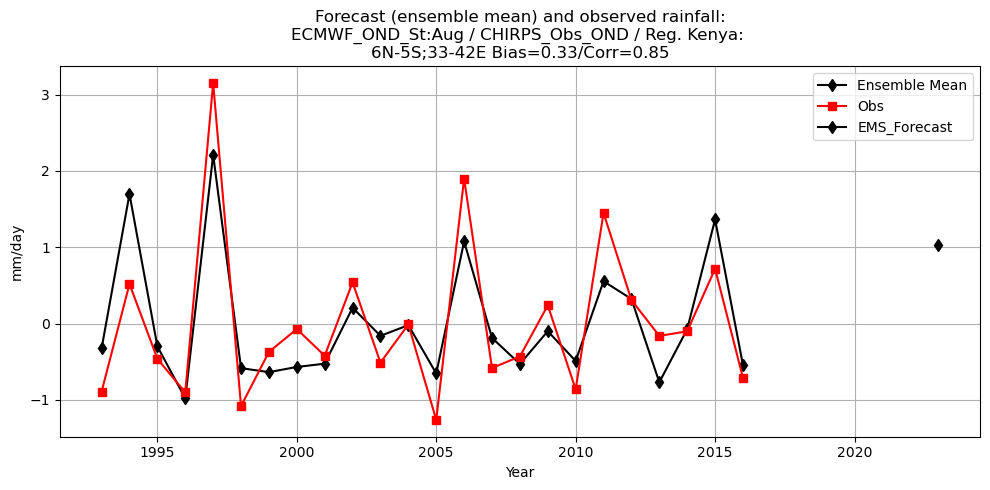

In [11]:
import matplotlib.pyplot as plt

# Replace these with your actual data
years = list(range(1993, 2017))
mean_forecast_rainfall = BC_Yearly_Forecast_mean
mean_observed_rainfall = Obs_Anom
Forecast_Mean = FC_Mean_Anom
year = 2023

plt.figure(figsize=(10, 5))

# Plot forecast rainfall
plt.plot(
    years,
    mean_forecast_rainfall,
    linestyle='-',
    marker='d',
    color='black',
    label='Ensemble Mean'
)

# Plot observed rainfall
plt.plot(
    years,
    mean_observed_rainfall,
    linestyle='-',
    marker='s',
    color='red',
    label='Obs'
)

plt.plot(
    year,
    Forecast_Mean,
    linestyle='-',
    marker='d',
    color='black',
    label='EMS_Forecast')


# Labels and title
plt.xlabel('Year')
plt.ylabel('mm/day')
plt.title(
    'Forecast (ensemble mean) and observed rainfall:\n'
    'ECMWF_OND_St:Aug / CHIRPS_Obs_OND / Reg. Kenya: \n'
    '6N-5S;33-42E Bias=0.33/Corr=0.85'
)

# Legend and grid
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


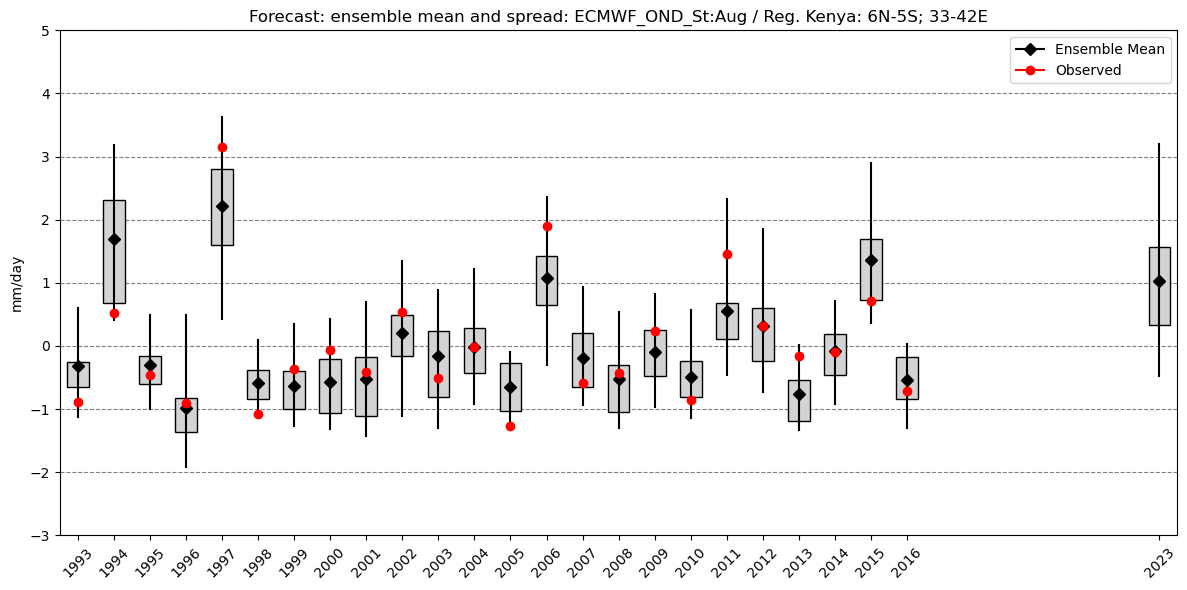

In [12]:
# Sample data for demonstration (replace with actual data)
years = da.year.values

#Observed
observed = Obs_Anom
#hindcast data
ensemble_mean = BC_Yearly_Forecast_mean
min_forecast = BC_Yearly_Forecast_min
max_forecast = BC_Yearly_Forecast_max
lower_quartile = BC_Yearly_Forecast_LQ
upper_quartile = BC_Yearly_Forecast_UQ
#FC data 
year_FC = 2023
Mean_FC = np.array(BC_Yearly_Forecast_mean_FC)
Min_FC = np.array(BC_Yearly_Forecast_min_FC)
Max_FC = np.array(BC_Yearly_Forecast_max_FC)
LQ_FC = np.array(BC_Yearly_Forecast_LQ_FC)
UQ_FC = np.array(BC_Yearly_Forecast_UQ_FC)


# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot box plots manually using quartiles and whiskers
for i, year in enumerate(years):
    # Draw the box (IQR) in grey
    ax.add_patch(plt.Rectangle((year - 0.3, lower_quartile[i]), 0.6, upper_quartile[i] - lower_quartile[i],
                               edgecolor='black', facecolor='lightgrey'))
    # Draw the whiskers (range)
    ax.plot([year, year], [min_forecast[i], max_forecast[i]], color='black')
    # Draw the ensemble mean as a black diamond (mean value)
    ax.plot(year, ensemble_mean[i], marker='D', color='black', label='Ensemble Mean' if i == 0 else "")
    # Draw the observed value as a black circle (Obs_rain)
    ax.plot(year, observed[i], marker='o', color='red', label='Observed' if i == 0 else "")

#Plot the forecast data
ax.add_patch(plt.Rectangle((year_FC - 0.3, LQ_FC[0]), 0.6, UQ_FC[0]- LQ_FC[0],
                               edgecolor='black', facecolor='lightgrey'))
ax.plot([year_FC, year_FC], [Min_FC[0], Max_FC[0]], color='black')
ax.plot(year_FC, Mean_FC[0], marker='D', color='black', label='Ensemble Mean' if i == 0 else "")

# Customise the plot
#x ticks 
# x ticks including forecast year
years_xticks = list(years) + [year_FC]
ax.set_xticks(years_xticks)
ax.set_xticklabels(years_xticks, rotation=45)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.set_ylabel('mm/day')
ax.set_title('Forecast: ensemble mean and spread: ECMWF_OND_St:Aug / Reg. Kenya: 6N-5S; 33-42E')
ax.set_xlim([1992.5, 2023.5])
ax.set_ylim([-3, 5])
ax.legend()

plt.tight_layout()
plt.show()


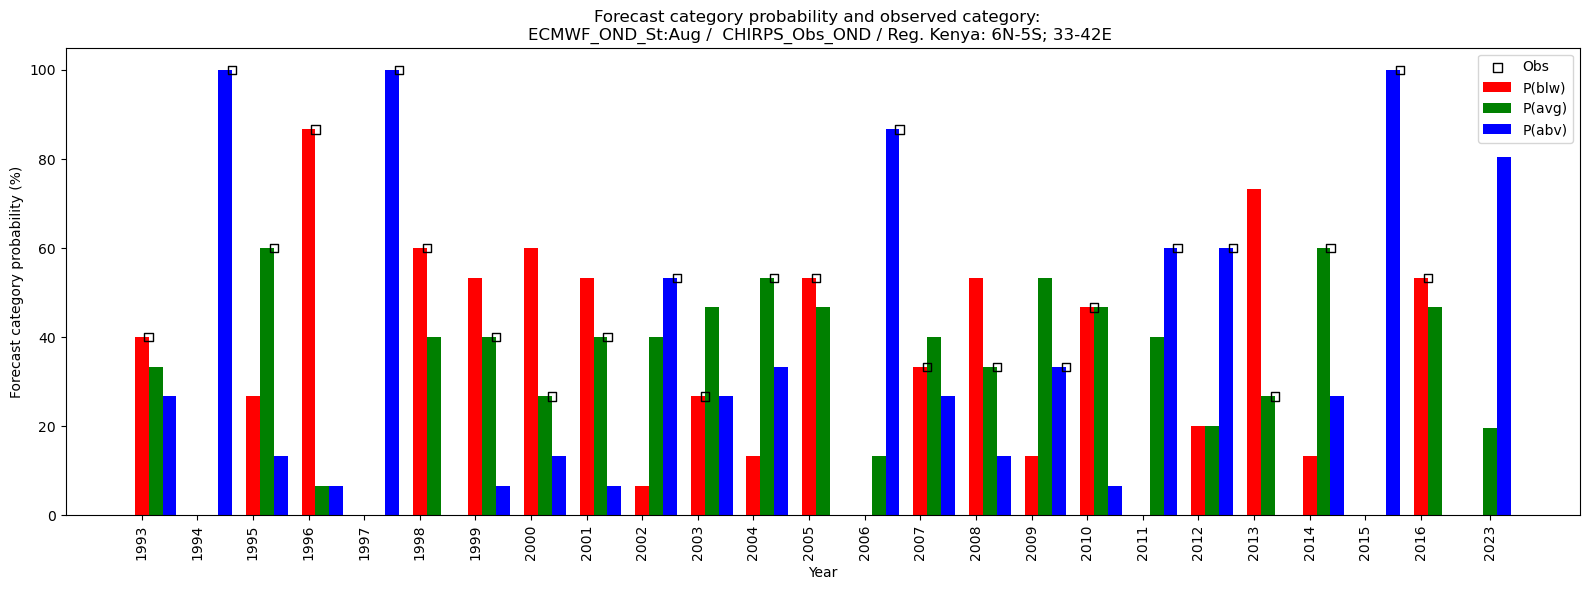

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define the years from 1981 to 2016
years = da.year.values

# Hindcast
percentage_of_lower_forecast_predictions = Yearly_percentage_Below
percentage_of_middle_forecast_predictions = Yearly_percentage_Between
percentage_of_above_forecast_predictions = Yearly_percentage_Above

#Forecast
fc_below = percentage_Below
fc_above = percentage_Above 
fc_between = percentage_Between

# Observed category values: 1=lower, 2=middle, 3=above
observed_category = RFA_Catagories

# Set bar width
bar_width = 0.25

# Set positions for each bar group
r1 = np.arange(len(years))
r2 = r1 + bar_width
r3 = r2 + bar_width

# Position for 2023 forecast bars
r4 = [len(years)]
r5 = [r4[0] + bar_width]
r6 = [r5[0] + bar_width]


# Create the plot
plt.figure(figsize=(16, 6))

# Plot the bars
plt.bar(r1, percentage_of_lower_forecast_predictions, color='red', width=bar_width, label='P(blw)')
plt.bar(r2, percentage_of_middle_forecast_predictions, color='green', width=bar_width, label='P(avg)')
plt.bar(r3, percentage_of_above_forecast_predictions, color='blue', width=bar_width, label='P(abv)')




plt.bar(r4, fc_below, color='red', width=bar_width,)
plt.bar(r5, fc_between, color='green', width=bar_width,)
plt.bar(r6, fc_above, color='blue', width=bar_width,)



# Plot the observed category as outlined black squares on top of the corresponding bars
obs_x = []
obs_y = []

for i, cat in enumerate(observed_category):
    if cat == 1:
        obs_x.append(r1[i] + bar_width / 2)
        obs_y.append(percentage_of_lower_forecast_predictions[i])
    elif cat == 2:
        obs_x.append(r2[i] + bar_width / 2)
        obs_y.append(percentage_of_middle_forecast_predictions[i])
    elif cat == 3:
        obs_x.append(r3[i] + bar_width / 2)
        obs_y.append(percentage_of_above_forecast_predictions[i])

plt.scatter(obs_x, obs_y, facecolors='none', edgecolors='black', marker='s', label='Obs')

# Set x-axis labels

xtick_positions = list(r1) + [r4[0] + bar_width]
xtick_labels = list(years) + [2023]
plt.xticks(xtick_positions, xtick_labels, rotation=90)



# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Forecast category probability (%)')
plt.title("Forecast category probability and observed category:  \nECMWF_OND_St:Aug /  CHIRPS_Obs_OND / Reg. Kenya: 6N-5S; 33-42E ")
plt.legend()

# Layout adjustment
plt.tight_layout()
plt.show()
